# Phase 1, Phase 2 tests

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [4]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [5]:
import jax
import hlax
import tomli
import optax
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from itertools import product
from flax.core import freeze, unfreeze
from flax.training.train_state import TrainState

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]["hist_loss"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Models

In [8]:
from typing import Callable

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=False, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = nn.elu(x)
        x = nn.Dense(100)(x)
        x = nn.elu(x)
        x = nn.Dense(100)(x)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    dim_latent: int
    n_hidden: int = 100
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        ...
        # self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        mean_z = nn.Dense(self.dim_latent)(z)
        logvar_z = nn.Dense(self.dim_latent, use_bias=True)(z)
        # logvar_z = self.logvar_diag
        return mean_z, logvar_z
    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        # self.mu = nn.Dense(self.dim_latent)
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def __call__(self, x):
        """
        Input x (_) is a dummy variable
        """
        z = self.mu
        # z = self.mu(x)
        return z, self.logvar_diag

    
class UnamortisedVAEBernDelta(nn.Module):
    """
    Base class for an unamortised variational autoencoder
    with Bernoulli decoder p(x|z) = Bern(x| f(z))
    and Dirac-delta encoder q(z|x) = delta(z = z^)
    """
    latent_dim: int
    obs_dim: int
    Encoder: nn.Module
    Decoder: nn.Module

    def setup(self):
        self.encoder = nn.vmap(
            self.Encoder,
            variable_axes={"params": 0},
            split_rngs={"params": True},
            in_axes=0,
        )(self.latent_dim)
        self.decoder = self.Decoder(self.obs_dim, self.latent_dim)

    def __call__(self, x, key_eps, num_samples=1):
        z = self.encoder(x)
        logit_mean_x = self.decoder(z)
        return z, logit_mean_x


class DeltaEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.z = self.param("z", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.z

## Setup

In [9]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=30_000, n_test=5_000, normalize=False)
X_warmup = warmup[0].round()
X_test = test[0].round()

In [10]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape

In [11]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    batch_size = 100
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10
    num_e_steps = 5
    num_m_steps = 0


In [12]:
num_epochs = 30
step = 50


config["train"]["learning_rate"] = 1e-4
config["train"]["hard_em"]["num_its_latent"] = 1
config["train"]["hard_em"]["num_its_params"] = 1
config["train"]["num_epochs"] = num_epochs
config["train"]["vae"]["num_is_samples"] = 5
# config["train"]["eval_epochs"] = [1] + list(range(0, num_epochs + step, step))[1:]
config["train"]["eval_epochs"] = [num_epochs]


config["test"]["learning_rate"] = 1e-3
config["test"]["num_epochs"] = 10
config["test"]["num_e_steps"] = 5
config["test"]["num_m_steps"] = 0
config["test"]["num_is_samples"] = 1

model_decoder = Decoder(28 ** 2, dim_latent)

# model_test = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
# config_test = hlax.unamortised.load_config(config, model_test)

# model_test = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)
# config_test = hlax.unamortised.load_test_config(config, model_test)

## Benchmark models

In [13]:
def elbo_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    var_z = jnp.exp(logvar_z)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)
    
    loss = (1 + logvar_z - mean_z ** 2 - var_z).sum(axis=-1) / 2 + log_prob_x.mean(axis=0)
    return -loss.mean()



def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

## Initialisiation

In [14]:
key_train, key_test = jax.random.split(key, 2)
key_init_test, key_it_test = jax.random.split(key_test, 2)

## Hard-EM

In [146]:
config = hlax.unamortised.CheckpointsConfig(
    num_epochs=20,
    batch_size=200,
    num_e_steps=10,
    eval_epochs=[],
)

In [147]:
%%time
model = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
tx_encoder = optax.adam(1e-3)
tx_decoder = optax.adam(1e-2)

output_train = hlax.unamortised.train_checkpoints(
    key_train, model, config, X_warmup, iwae_bern_delta, tx_encoder, tx_decoder
)
# checkpoint_params = output_train["checkpoint_params"]
state_encoder, state_decoder = output_train["state_final"]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 7.42 s, sys: 1.48 s, total: 8.9 s
Wall time: 6.74 s


In [148]:
params_decoder = state_decoder.params
params_test = model_test.init(key_init_test, X_test[:2], key_init_test)
params_test = unfreeze(params_test)
params_test["params"]["decoder"] = params_decoder
params_test = freeze(params_test)

tx = optax.adam(1e-4)
state = TrainState.create(
    apply_fn=model_test.apply,
    params=params_test,
    tx=tx
)

config_test = hlax.amortised.Config(
    num_epochs=200,
    batch_size=200
)

state_hem, hist_loss_hem = hlax.amortised.train_encoder(key_it_test, config_test, X_test, state, elbo_bern)

  0%|          | 0/200 [00:00<?, ?it/s]

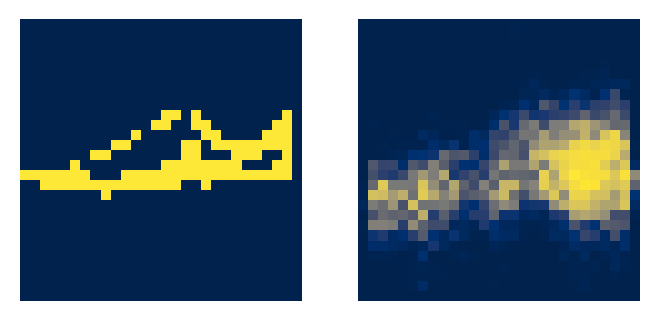

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = model_test.apply(state_hem.params, X_test, key)[2][1]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

## VAE

In [140]:
model = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
config = hlax.amortised.CheckpointsConfig(
    num_epochs=20,
    batch_size=200,
    eval_epochs=[],
)

In [141]:
%%time

tx_vae = optax.adam(1e-3)
# tx_decoder = optax.adam(1e-2)

output_train = hlax.amortised.train_checkpoints(
    key_train, model, config, X_warmup, elbo_bern, tx_vae
)
# checkpoint_params = output_train["checkpoint_params"]
state_vae = output_train["state_final"]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 6.87 s, sys: 942 ms, total: 7.81 s
Wall time: 4.23 s


In [142]:
params_decoder = state_vae.params["params"]["decoder"]
params_test = model_test.init(key_init_test, X_test[:2], key_init_test)
params_test = unfreeze(params_test)
params_test["params"]["decoder"] = params_decoder
params_test = freeze(params_test)

tx = optax.adam(1e-4)
state = TrainState.create(
    apply_fn=model_test.apply,
    params=params_test,
    tx=tx
)

config_test = hlax.amortised.Config(
    num_epochs=200,
    batch_size=200
)

state_vae, hist_loss_vae = hlax.amortised.train_encoder(key_it_test, config_test, X_test, state, elbo_bern)

  0%|          | 0/200 [00:00<?, ?it/s]

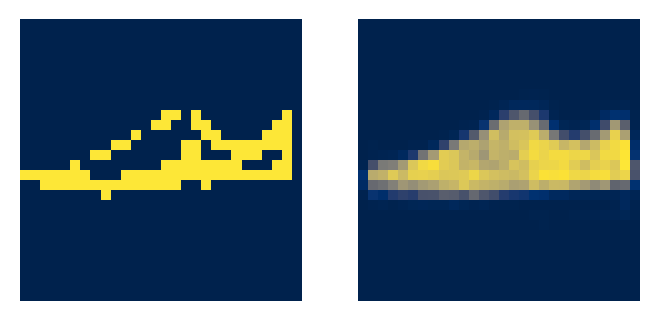

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = model_test.apply(state_vae.params, X_test, key)[2][1]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

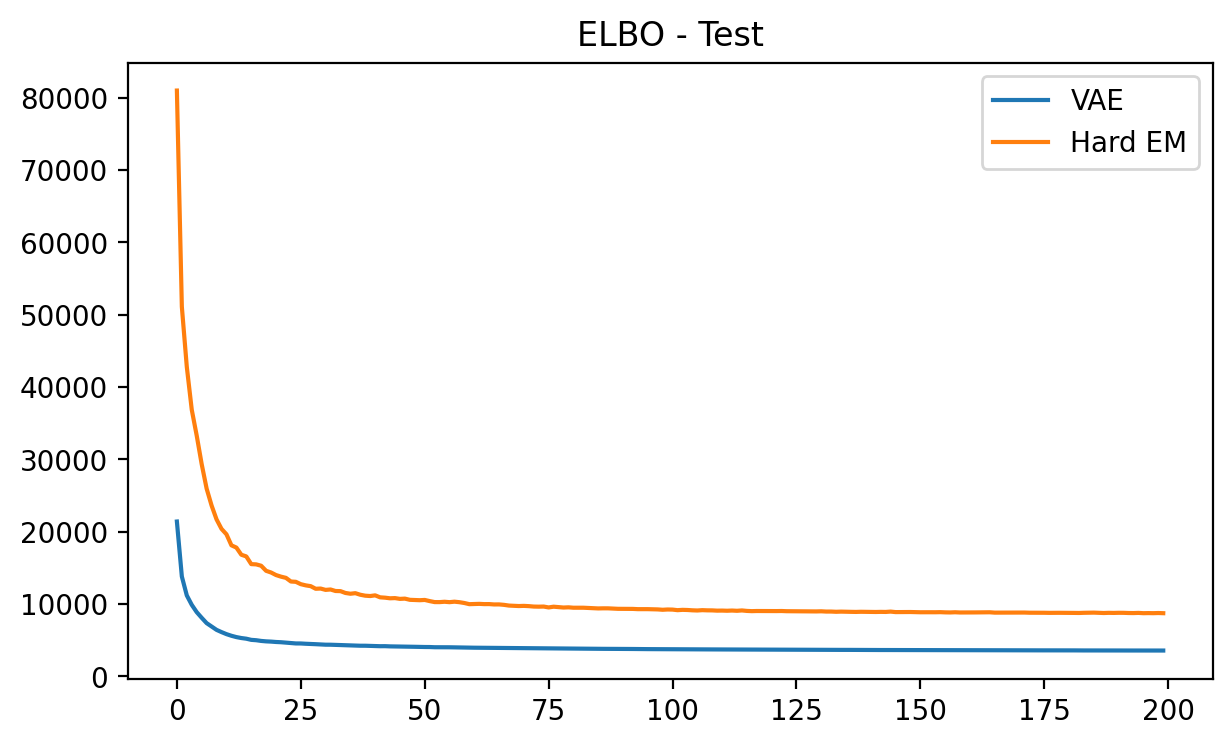

In [150]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.title("ELBO - Test")
plt.plot(hist_loss_vae, label="VAE")
plt.plot(hist_loss_hem, label="Hard EM")
plt.legend()